In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import math

In [508]:
path = "CAPE_ALL.xlsx"
df = pd.read_excel(path,sheet_name=0)
df = df.dropna(subset=['CAPE'])
df.reset_index(drop=True, inplace=True)
df.head()

,Date,P,D,E,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Scale Earnings,CAPE,TR CAPE,Yield,Monthly Bond Returns,Real Bond Returns,Stock Real Return 10 Yr,Bond Real Return 10 Yr,Returns
0,1881.01,6.19,0.265,0.4858,9.419420,1881.041667,3.700000,207.242891,8.872272,383.409300,16.264717,30.090507,18.473952,24.135057,-0.010489,1.003636,2.422306,0.045353,0.056468,-0.011115
1,1881.02,6.17,0.270,0.4817,9.514585,1881.125000,3.693333,204.507131,8.949259,379.727725,15.966140,29.645842,18.147258,23.655503,-0.011393,1.003631,2.406798,0.046774,0.056199,-0.009425
2,1881.03,6.24,0.275,0.4775,9.514585,1881.208333,3.686667,206.827309,9.114986,385.446207,15.826930,29.495283,18.270119,23.767713,-0.013123,1.003625,2.415537,0.042423,0.054885,-0.012462
3,1881.04,6.22,0.280,0.4733,9.609669,1881.291667,3.680000,204.124477,9.188883,381.836216,15.532494,29.055158,17.950108,23.308850,-0.007504,1.003620,2.400307,0.045971,0.054635,-0.008665
4,1881.05,6.50,0.285,0.4692,9.514585,1881.375000,3.673333,215.445114,9.446440,404.485199,15.551823,29.197609,18.869719,24.456686,-0.008881,1.003615,2.433070,0.041157,0.054786,-0.013628


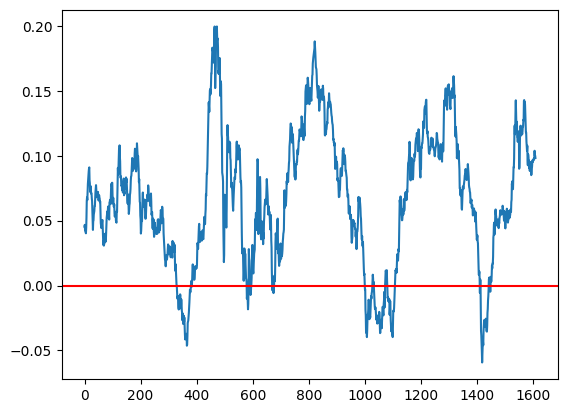

In [528]:
plt.plot(df["Stock Real Return 10 Yr"])
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [393]:
def get_real_bond_returns():
    bond_returns = [math.nan]*120
    for i in range(len(df)-120):
        bond_returns.append( ((df['Real Bond Returns'][i+120]/df['Real Bond Returns'][i])**(0.1)-1) )
    return bond_returns

df["Bond_Returns_10Y"] = get_real_bond_returns()

In [396]:
# Realized Volatility of S&P 500
df["Price Change"] = df["P"].pct_change()
df["S&P Vol"] = df["Price Change"].rolling(window=12).std()

# Realized Volatility of Real Bond yields
df["Yield Change"] = df["Real Bond Returns"].diff()
df["Bond Vol"] = df["Yield Change"].rolling(window=12).std()

# YOY Inflation
df["Inflation"] = df["CPI"].pct_change(12)

# E/P Ratio
df["1/CAPE"] = 1/df["CAPE"]

# Bond Yield
df["Bond Yield"] = df["Bond_Returns_10Y"]

In [398]:
var = ["1/CAPE", "Inflation", "S&P Vol", "Bond Vol", "Bond Yield" ]

for v in var:
    for lag in range(1, 13):
        df[f"{v}_lag_{lag}"] = df[v].shift(lag)


In [399]:
df = df.dropna(subset=var)
df.reset_index(drop=True, inplace=True)

In [403]:
start_idx = 540  # jan 1926
end_idx = 948   # dec 1960

In [404]:
train_df = df[start_idx:end_idx]  # jan 1926 - dec 1966
test_df = df[end_idx:]  

In [405]:
len(train_df), len(test_df), len(df[540:])

(408, 661, 1069)

In [406]:
# implement 
def create_sequences(data, seq_length = 12):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)


In [407]:
seq_length = 12
X = create_sequences(df[var])
y = df[var][12:].values

In [408]:
X_train, y_train = X[start_idx-12:end_idx-12], y[start_idx-12:end_idx-12]
X_test, y_test = X[end_idx-12:], y[end_idx-12:]

In [409]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [410]:
y_train.shape,y_test.shape

((408, 5), (661, 5))

In [411]:
print(X_test.shape)

(661, 60)


In [412]:
len(X_train), len(y_train), len(X_test), len(y_test)

(408, 408, 661, 661)

In [413]:
y_train[0]

array([0.05852279, 0.01470588, 0.04688931, 0.05662224, 0.07004551])

In [414]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [415]:
from sklearn.ensemble import RandomForestRegressor

predictions = []
actual = []

for idx in range(len(X_test)):
    
    x_t = X_test[idx].reshape(1, -1)
    y_t = y_test[idx].reshape(1, -1)

    y_pred = model.predict(x_t)

    predictions.append(y_pred)
    actual.append(y_t)

    model.fit(x_t, y_t)


In [416]:
predictions_cape = []
actual_cape = []

for idx in range(len(predictions)):
    
   predictions_cape.append(predictions[idx][0][0])
   actual_cape.append(actual[idx][0][0])

0.00256883194371818

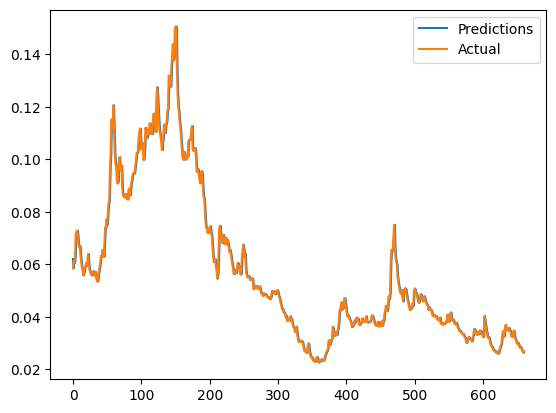

In [417]:
plt.plot(predictions_cape, label='Predictions')
plt.plot(actual_cape, label='Actual')
plt.legend()

# rmse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_cape, predictions_cape)
rmse = np.sqrt(mse)
rmse


In [483]:
predicted_earnings = []
predicted_div = []

growth_m = df[start_idx:end_idx]["E"].pct_change().mean()
growth_y = df[start_idx:end_idx]["E"].pct_change(120).mean()
payout_ratio = (df["D"][540:948]/df["E"][540:948]).median()


curr_earnings = df["E"].iloc[end_idx - 1]

for i in range(len(test_df)):
    predicted_earnings.append(curr_earnings * (1 + growth_m))
    predicted_div.append(predictions_cape[i] * payout_ratio)
    curr_earnings = predicted_earnings[-1]

    

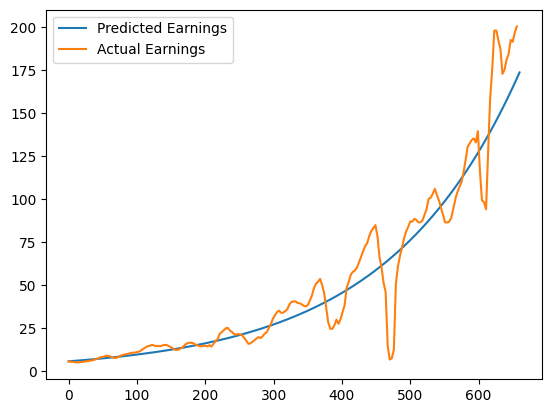

In [484]:
plt.plot(predicted_earnings, label='Predicted Earnings')
plt.plot(test_df["E"].to_numpy(), label='Actual Earnings')
plt.legend()


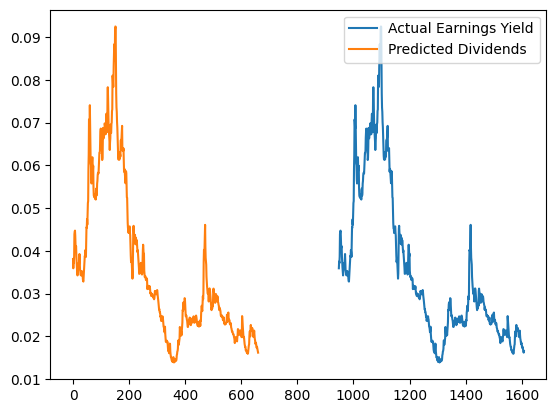

In [486]:
# earnings yield
plt.plot(1/test_df["CAPE"] * payout_ratio, label='Actual Earnings Yield')
plt.plot(predicted_div, label='Predicted Dividends')
# plt.plot(test_df["D"].to_numpy(), label='Actual Dividends')
plt.legend()

In [487]:
test_df.loc[:,"Predicted E"] = predicted_earnings
test_df.loc[:,"Predicted D"] = predicted_div

In [520]:
PRED_CAPE = [x for x in predictions_cape]
test_df.loc[:,"Predicted CAPE"] = PRED_CAPE
test_df.loc[:,"Change CAPE"] = test_df["Predicted CAPE"].pct_change(120)

In [521]:
test_df.head()

,Date,P,D,E,CPI,Fraction,Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Bond Yield_lag_8,Bond Yield_lag_9,Bond Yield_lag_10,Bond Yield_lag_11,Bond Yield_lag_12,Predicted E,Predicted D,Predicted CAPE,Change CAPE,R_10
948,1970.01,90.31,3.16333,5.73000,37.8,1970.041667,7.79,753.454777,26.391608,110944.840660,...,0.006705,0.006374,0.004367,0.005586,0.007939,5.809827,0.038102,0.062059,NaN,NaN
949,1970.02,87.16,3.16667,5.68000,38.0,1970.125000,7.24,723.347148,26.280423,106834.025882,...,0.005074,0.006705,0.006374,0.004367,0.005586,5.839808,0.035925,0.058512,NaN,NaN
950,1970.03,88.65,3.17000,5.63000,38.2,1970.208333,7.07,731.860866,26.170321,108413.550860,...,0.004451,0.005074,0.006705,0.006374,0.004367,5.869944,0.037500,0.061078,NaN,NaN
951,1970.04,85.95,3.17333,5.59333,38.5,1970.291667,7.39,704.041565,25.993673,104613.442870,...,0.004558,0.004451,0.005074,0.006705,0.006374,5.900236,0.037139,0.060490,NaN,NaN
952,1970.05,76.06,3.17667,5.55667,38.6,1970.375000,7.91,621.415619,25.953620,92657.434850,...,0.003438,0.004558,0.004451,0.005074,0.006705,5.930683,0.038680,0.063000,NaN,NaN


In [491]:
# # earnings yield
# plt.plot(test_df["Predicted D"]/test_df["P"], label='Predicted Earnings Yield')
# plt.plot(test_df["D"]/test_df["P"], label='Actual Earnings Yield')
# plt.legend()

In [492]:
# plt.plot(test_df["Change CAPE"], label='Predicted CAPE Change')

In [522]:
growth_y

1.0176907674811086

In [529]:
test_df.loc[:,"R_10"] = (growth_y/100) + (test_df["Change CAPE"]) + (test_df["Predicted D"])

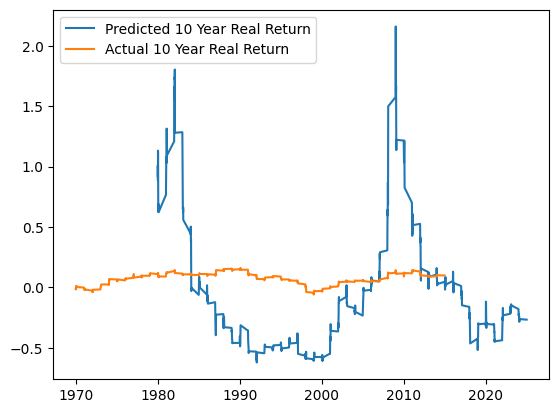

In [530]:
plt.plot(test_df["Date"],test_df["R_10"], label='Predicted 10 Year Real Return')
plt.plot(test_df["Date"],test_df["Stock Real Return 10 Yr"], label='Actual 10 Year Real Return')
plt.legend()

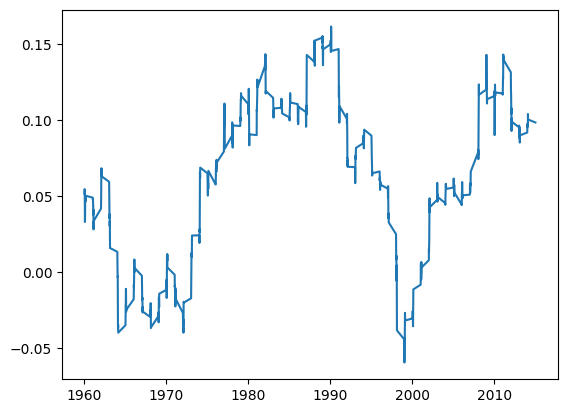

In [527]:
plt.plot(df["Date"][948:],df["Stock Real Return 10 Yr"][948:])

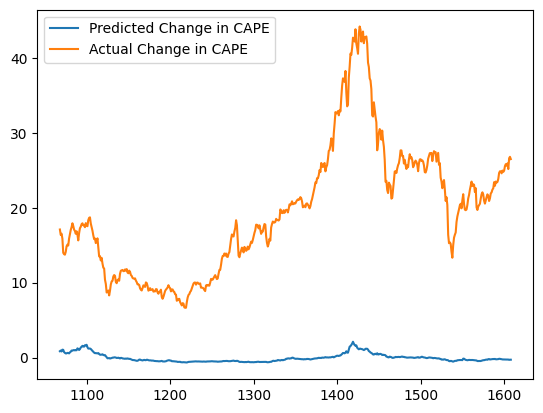

In [478]:
plt.plot(test_df["Change CAPE"], label='Predicted Change in CAPE')
plt.plot(test_df["CAPE"].shift(120), label='Actual Change in CAPE')
plt.legend()
# rmse
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(test_df["Returns"], test_df["R_10"])
# rmse = np.sqrt(mse)


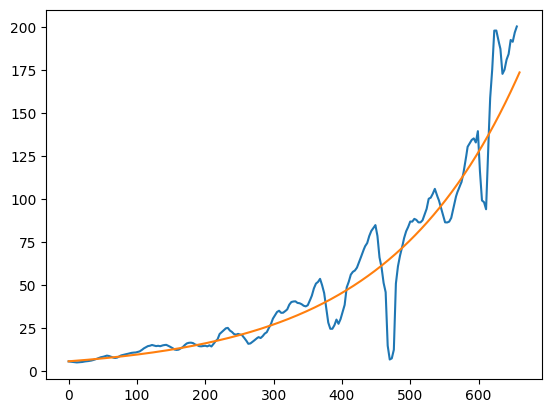

In [435]:
plt.plot(df[end_idx:]["E"].to_numpy(), label='Actual Earnings')
plt.plot(predicted_earnings, label='Predicted Earnings')

In [436]:
len(df[end_idx:]), len(predicted_earnings)

(661, 661)

In [ ]:
growth_m = df[start_idx:end_idx]["E"].pct_change().mean()

In [434]:
start_earnings = df["E"].iloc[end_idx - 1]
predicted_earnings = []
for i in range(len(test_df)):
    predicted_earnings.append(start_earnings * (1 + growth_m))
    start_earnings = predicted_earnings[-1]



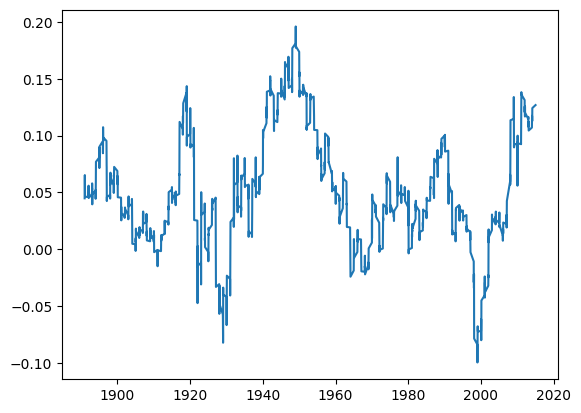

In [507]:
plt.plot(df["Date"],df["Returns"], label='Predicted 10 Year Real Return')